In [1]:
import math
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import scipy.stats as stats

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori
from numpy.lib.arraysetops import intersect1d
from mlxtend.frequent_patterns import association_rules

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from google.colab import files as colab_files
uploaded = colab_files.upload()

Saving steam.csv to steam.csv


In [2]:
steam_df = pd.read_csv('steam.csv')

# Preprocessing for Generic Steam Data

In [3]:
steam_df.head(1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19


*   Collect all the unique category tags in a list called '**category_tags_list**' from the column called '**categories**' of **steam_df**.

In [4]:
# build a list to store all the category tags
category_tags_list = []
for (colName, colData) in steam_df.iteritems():
  if(colName == 'categories'):
    for row in colData:
      temp_arr = row.split(';')
      for ele in temp_arr:
        if ele not in category_tags_list:
          category_tags_list.append(ele)

# build a hash map for game tags
idx = 0
tags_hash_mp = dict()
while(idx < len(category_tags_list)):
  tags_hash_mp[f'#{idx+1}'] = category_tags_list[idx]
  idx += 1

uniq_category_tags_num = len(category_tags_list)
print(f'There are {uniq_category_tags_num} steam game tags in the column called "categories".')

There are 29 steam game tags in the column called "categories".


*   Collect all the unique genre tags in a list called '**category_tags_list**' from the column called '**categories**' of **steam_df**.

In [5]:
# build a list to store all the category tags
genres_list = []
for (colName, colData) in steam_df.iteritems():
  if(colName == 'genres'):
    for row in colData:
      temp_arr = row.split(';')
      for ele in temp_arr:
        if ele not in genres_list:
          genres_list.append(ele)

# build a hash map for game tags
idx = 0
tags_hash_mp = dict()
while(idx < len(genres_list)):
  tags_hash_mp[f'#{idx+1}'] = genres_list[idx]
  idx += 1

uniq_genre_tags_num = len(genres_list)
print(f'There are {uniq_genre_tags_num} steam game tags in the column called "categories".')

There are 29 steam game tags in the column called "categories".


*   Collect all the unique category tags in a list called '**category_tags_list**' from the column called '**steamspy_tags**' of **steam_df**.

In [6]:
# build a list to store all the steam spy category tags
spy_tags_list = []
for (colName, colData) in steam_df.iteritems():
  if(colName == 'steamspy_tags'):
    for row in colData:
      temp_arr = row.split(';')
      for ele in temp_arr:
        if ele not in spy_tags_list:
          spy_tags_list.append(ele)

# build a hash map for game tags
idx = 0
tags_hash_mp = dict()
while(idx < len(spy_tags_list)):
  tags_hash_mp[f'#{idx+1}'] = spy_tags_list[idx]
  idx += 1

uniq_steam_spy_num = len(spy_tags_list)
print(f'There are {uniq_steam_spy_num} steam game tags in the column called "steamspy_tags".')

There are 339 steam game tags in the column called "steamspy_tags".


Some helper functions:
*   outputFrame_with_column: generate a pandas dataframe with a designated column
*   extract_year: extract the integer that represents the year number
*   extract_tags: extract ';' concatenated tags stored in each row and return a numpy array that stores them
*   extract_platforms: extract ';' concatenated platform types stored in each row and return a numpy array that stores them
*   extract_owners: replace the original owners range with a mean value of the bounds of the owners range

In [7]:
# def outputFrame_with_column(arr, column=['']):
#   return pd.DataFrame(arr, columns=column)

def extract_semicolon(post):
  return post.split(';')

def extract_categories(post):
  return np.array(post.split(';'))

def extract_year(post):
  time = post.split('-')
  return time[0]

def extract_tags(post):
  result = []
  splitted = post.split(';')
  for key, val in tags_hash_mp.items():
    for ele in splitted:
      if ele == val:
        result.append(key)
  return np.array(result)

def extract_platforms(post):
  return np.array(post.split(';'))

def extract_owners(post):
  splitted = post.split('-')
  result = (int(splitted[0]) + int(splitted[1])) / 2
  return result

Helper functaions create some features and update some existing featues in the dataframe:
*   outputFrame_with_column: generate a pandas dataframe with a designated column
*   extract_year: extract the integer that represents the year number
*   extract_tags: extract ';' concatenated tags stored in each row and return a numpy array that stores them
*   extract_platforms: extract ';' concatenated platform types stored in each row and return a numpy array that stores them
*   extract_owners: replace the original owners range with a mean value of the bounds of the owners range

In [8]:
# categories_df = outputFrame_with_column(steam_df, column=['categories'])
steam_df['categories'] = steam_df['categories'].apply(extract_semicolon)
steam_df['platforms'] = steam_df['platforms'].apply(extract_semicolon)
steam_df['genres'] = steam_df['genres'].apply(extract_semicolon)
steam_df['steamspy_tags'] = steam_df['steamspy_tags'].apply(extract_semicolon)
steam_df['year'] = steam_df['release_date'].apply(extract_year)
steam_df['owners'] = steam_df['owners'].apply(extract_owners)
steam_df['total_ratings'] = steam_df['positive_ratings'] + steam_df['negative_ratings']
steam_df['pos_rate'] = round(steam_df['positive_ratings'] / steam_df['total_ratings'], 5)

In [9]:
steam_df.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price', 'year',
       'total_ratings', 'pos_rate'],
      dtype='object')

In [10]:
steam_df.head(1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,year,total_ratings,pos_rate
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],...,0,124534,3339,17612,317,15000000.0,7.19,2000,127873,0.97389


In [11]:
steam_array_df = steam_df[['appid', 'name', 'platforms', 'categories', 'genres', 'steamspy_tags']]
steam_categorical_df = steam_df[['appid', 'name', 'english', 'developer', 'publisher']]
steam_numeric_df = steam_df[['appid', 'name', 'required_age', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price', 'year', 'total_ratings', 'pos_rate']]

In [12]:
steam_array_df

,appid,name,platforms,categories,genres,steamspy_tags
0,10,Counter-Strike,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
1,20,Team Fortress Classic,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
2,30,Day of Defeat,"[windows, mac, linux]","[Multi-player, Valve Anti-Cheat enabled]",[Action],"[FPS, World War II, Multiplayer]"
3,40,Deathmatch Classic,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"
4,50,Half-Life: Opposing Force,"[windows, mac, linux]","[Single-player, Multi-player, Valve Anti-Cheat...",[Action],"[FPS, Action, Sci-fi]"
...,...,...,...,...,...,...
27070,1065230,Room of Pandora,[windows],"[Single-player, Steam Achievements]","[Adventure, Casual, Indie]","[Adventure, Indie, Casual]"
27071,1065570,Cyber Gun,[windows],[Single-player],"[Action, Adventure, Indie]","[Action, Indie, Adventure]"
27072,1065650,Super Star Blast,[windows],"[Single-player, Multi-player, Co-op, Shared/Sp...","[Action, Casual, Indie]","[Action, Indie, Casual]"
27073,1066700,New Yankee 7: Deer Hunters,"[windows, mac]","[Single-player, Steam Cloud]","[Adventure, Casual, Indie]","[Indie, Casual, Adventure]"


In [13]:
steam_numeric_df.rename({'positive_ratings': 'pos_ratings', 'negative_ratings': 'neg_ratings', 'average_playtime': 'avg_playtime'}, axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [14]:
steam_categorical_df.head()

,appid,name,english,developer,publisher
0,10,Counter-Strike,1,Valve,Valve
1,20,Team Fortress Classic,1,Valve,Valve
2,30,Day of Defeat,1,Valve,Valve
3,40,Deathmatch Classic,1,Valve,Valve
4,50,Half-Life: Opposing Force,1,Gearbox Software,Valve


In [15]:
# status that whether support English or not
english_status = steam_categorical_df['english'].unique()
english_status_len = len(english_status)
print(f'There are {english_status_len} statuses for English version: {english_status}')

# 17113 unique
uniq_developers_num = len(steam_categorical_df['developer'].unique())
print(f'There are {uniq_developers_num} unique steam game developers in this dataframe.')

# game publisher
uniq_publishers_num = len(steam_categorical_df['publisher'].unique())
print(f'There are {uniq_publishers_num} unique steam game publishers in this dataframe.')

# game genres
# uniq_genres_num = len(steam_array_df['genres'].unique())
# print(f'There are {uniq_genres_num} unique steam game genres in this dataframe.')

There are 2 statuses for English version: [1 0]
There are 17113 unique steam game developers in this dataframe.
There are 14354 unique steam game publishers in this dataframe.


In [16]:
steam_numeric_df.drop(labels=['appid', 'name'], axis=1).describe()

,required_age,achievements,pos_ratings,neg_ratings,avg_playtime,median_playtime,owners,price,total_ratings,pos_rate
count,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,2.707500e+04,27075.000000,2.707500e+04,27075.000000
mean,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,1.340905e+05,6.078193,1.211586e+03,0.714478
std,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,1.328089e+06,7.874922,2.242909e+04,0.233594
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,1.000000e+04,0.000000,1.000000e+00,0.000000
25%,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.000000e+04,1.690000,1.000000e+01,0.583330
50%,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,1.000000e+04,3.990000,3.600000e+01,0.760330
75%,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,3.500000e+04,7.190000,1.760000e+02,0.893905
max,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,1.500000e+08,421.990000,3.046717e+06,1.000000


In [17]:
steam_numeric_df.corr()

,appid,required_age,achievements,pos_ratings,neg_ratings,avg_playtime,median_playtime,owners,price,total_ratings,pos_rate
appid,1.000000,-0.087740,0.040510,-0.070888,-0.052198,-0.070236,-0.048308,-0.127310,-0.152112,-0.069987,-0.022049
required_age,-0.087740,1.000000,-0.005459,0.060418,0.057599,0.034423,0.014748,0.074438,0.120358,0.062154,0.010254
achievements,0.040510,-0.005459,1.000000,0.006058,0.003578,0.014175,0.009957,0.003400,-0.007996,0.005813,-0.022420
pos_ratings,-0.070888,0.060418,0.006058,1.000000,0.762804,0.157898,0.035776,0.713448,0.036110,0.992340,0.030240
neg_ratings,-0.052198,0.057599,0.003578,0.762804,1.000000,0.161140,0.047887,0.690306,0.051259,0.836842,0.000776
avg_playtime,-0.070236,0.034423,0.014175,0.157898,0.161140,1.000000,0.914900,0.174157,0.049242,0.164463,0.020407
median_playtime,-0.048308,0.014748,0.009957,0.035776,0.047887,0.914900,1.000000,0.035983,0.036610,0.039437,0.013233
owners,-0.127310,0.074438,0.003400,0.713448,0.690306,0.174157,0.035983,1.000000,0.031071,0.735892,0.035163
price,-0.152112,0.120358,-0.007996,0.036110,0.051259,0.049242,0.036610,0.031071,1.000000,0.040363,0.076455
total_ratings,-0.069987,0.062154,0.005813,0.992340,0.836842,0.164463,0.039437,0.735892,0.040363,1.000000,0.025750


In [18]:
def extract_freq_itemsets(post):
  temp_arr = [element for element in post]
  return set(np.unique(temp_arr))

# steam_df['itemset'] = steam_df['tags'].apply(extract_freq_itemsets)
# steam_df.head(3)

# Exploratory Data Analysis

*   Steam Categorical Data

In [19]:
len(steam_array_df.columns)

6

In [20]:
steam_array_df.head(1)

,appid,name,platforms,categories,genres,steamspy_tags
0,10,Counter-Strike,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"


In [21]:
steam_categorical_df.head(1)

,appid,name,english,developer,publisher
0,10,Counter-Strike,1,Valve,Valve


**Column called 'english'**
*   two statuses exist, 1 means support English Version, 0 means not support English Version.

In [22]:
steam_categorical_df['english'].value_counts()

1    26564
0      511
Name: english, dtype: int64

**Section 2.1.1 - count the number of the games that support English vs. those not supoort**

In [23]:
english_dict = {'support English': 26564, 'not support English': 511}
column_labels = list(english_dict.keys())
column_values = list(english_dict.values())

**Section 2.1.2 - Plot the Bar Plot of the English Games vs. the Non-English Games**

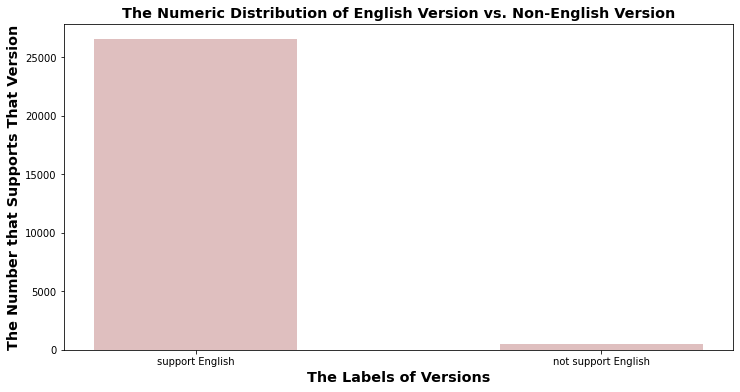

In [24]:
fig = plt.figure(figsize = (12, 6))
plt.bar(column_labels, column_values, color ='maroon', width=0.5, alpha=0.25)
plt.xlabel("The Labels of Versions", fontweight='bold', fontsize='x-large')
plt.ylabel("The Number that Supports That Version", fontweight='bold', fontsize='x-large')
plt.title("The Numeric Distribution of English Version vs. Non-English Version", fontweight='bold', fontsize='x-large')
plt.show()

**Section 2.1.2 - Build a dictionary that records the number of the published games from each developer**

In [25]:
developers_dict = dict()
for (colName, colData) in steam_categorical_df.iteritems():
  if (colName == 'developer'):
    for row in colData:
      if row not in developers_dict.keys():
        developers_dict[row] = 1
      else:
        developers_dict[row] += 1

*   sort the dictionaries according to their values 



In [26]:
value_key_pairs = ((value, key) for (key,value) in developers_dict.items())
sorted_value_key_pairs = sorted(value_key_pairs, reverse=True)
sorted_developers_dict = {k: v for v, k in sorted_value_key_pairs}



> Based on the value-sorted dictionary of developers, I see that the highest-productivity developers made 94 games in the steam platform.



**Section 2.1.3 - Build a dictionary that records the published game number in descending order**

In [27]:
published_game_stats_dict = dict()
for key, val in sorted_developers_dict.items():
  if(str(val) in published_game_stats_dict.keys()):
    published_game_stats_dict[str(val)] += 1
  else:
    published_game_stats_dict[str(val)] = 1

**Section 2.1.4 - Visualize the developer number with their corresponding published game number**

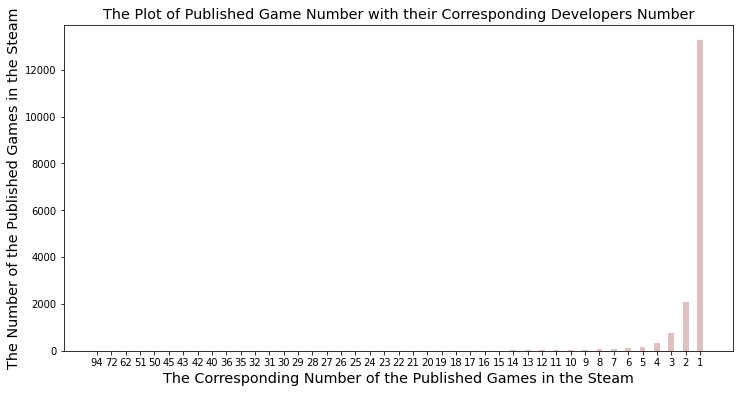

In [28]:
courses = list(published_game_stats_dict.keys())
values = list(published_game_stats_dict.values())
  
fig = plt.figure(figsize = (12, 6))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon', width = 0.4, alpha=0.25)
 
plt.xlabel("The Corresponding Number of the Published Games in the Steam", fontsize='x-large')
plt.ylabel("The Number of the Published Games in the Steam", fontsize='x-large')
plt.title("The Plot of Published Game Number with their Corresponding Developers Number", fontsize='x-large')
plt.show()

*   Steam Numerical Data

In [29]:
steam_numeric_df

,appid,name,required_age,achievements,pos_ratings,neg_ratings,avg_playtime,median_playtime,owners,price,year,total_ratings,pos_rate
0,10,Counter-Strike,0,0,124534,3339,17612,317,15000000.0,7.19,2000,127873,0.97389
1,20,Team Fortress Classic,0,0,3318,633,277,62,7500000.0,3.99,1999,3951,0.83979
2,30,Day of Defeat,0,0,3416,398,187,34,7500000.0,3.99,2003,3814,0.89565
3,40,Deathmatch Classic,0,0,1273,267,258,184,7500000.0,3.99,2001,1540,0.82662
4,50,Half-Life: Opposing Force,0,0,5250,288,624,415,7500000.0,3.99,1999,5538,0.94800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,0,7,3,0,0,0,10000.0,2.09,2019,3,1.00000
27071,1065570,Cyber Gun,0,0,8,1,0,0,10000.0,1.69,2019,9,0.88889
27072,1065650,Super Star Blast,0,24,0,1,0,0,10000.0,3.99,2019,1,0.00000
27073,1066700,New Yankee 7: Deer Hunters,0,0,2,0,0,0,10000.0,5.19,2019,2,1.00000


In [30]:
steam_numeric_df.describe()

,appid,required_age,achievements,pos_ratings,neg_ratings,avg_playtime,median_playtime,owners,price,total_ratings,pos_rate
count,2.707500e+04,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,2.707500e+04,27075.000000,2.707500e+04,27075.000000
mean,5.962035e+05,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,1.340905e+05,6.078193,1.211586e+03,0.714478
std,2.508942e+05,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,1.328089e+06,7.874922,2.242909e+04,0.233594
min,1.000000e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,1.000000e+04,0.000000,1.000000e+00,0.000000
25%,4.012300e+05,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.000000e+04,1.690000,1.000000e+01,0.583330
50%,5.990700e+05,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,1.000000e+04,3.990000,3.600000e+01,0.760330
75%,7.987600e+05,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,3.500000e+04,7.190000,1.760000e+02,0.893905
max,1.069460e+06,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,1.500000e+08,421.990000,3.046717e+06,1.000000


**Section 2.2.2 - Plot the ranking of the Median Playtime of Each Published Steam Game**

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25042 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20185 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25042 missing from current font.
  font.set_

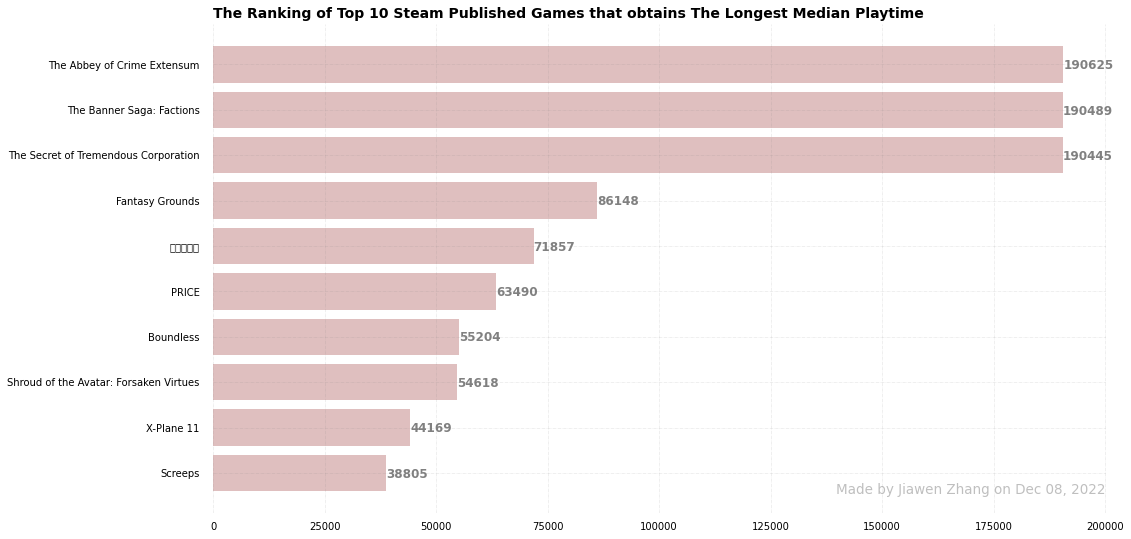

In [31]:
df = steam_numeric_df[['appid', 'name', 'median_playtime']]
df_sorted_desc= df.sort_values('median_playtime',ascending=False)
 
name_col = df_sorted_desc['name'].head(10)
median_playtime_col = df_sorted_desc['median_playtime'].head(10)
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name_col, median_playtime_col, color='maroon', alpha=0.25)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.25)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 12, fontweight ='bold', color ='grey')
 
# Add Plot Title
ax.set_title('The Ranking of Top 10 Steam Published Games that obtains The Longest Median Playtime', loc ='left', fontsize = 14, fontweight ='bold')
 
# Add Text watermark
fig.text(0.9, 0.15, 'Made by Jiawen Zhang on Dec 08, 2022', fontsize = 13.5, color ='grey', ha ='right', va ='bottom', alpha = 0.5)
 
# Show Plot
plt.show()

**Section 2.2.3 - Plot the ranking of the Owner Number of Each Published Steam Game**

<ipython-input-32-44e8741ef4cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['owners'] = df['owners']/1000000


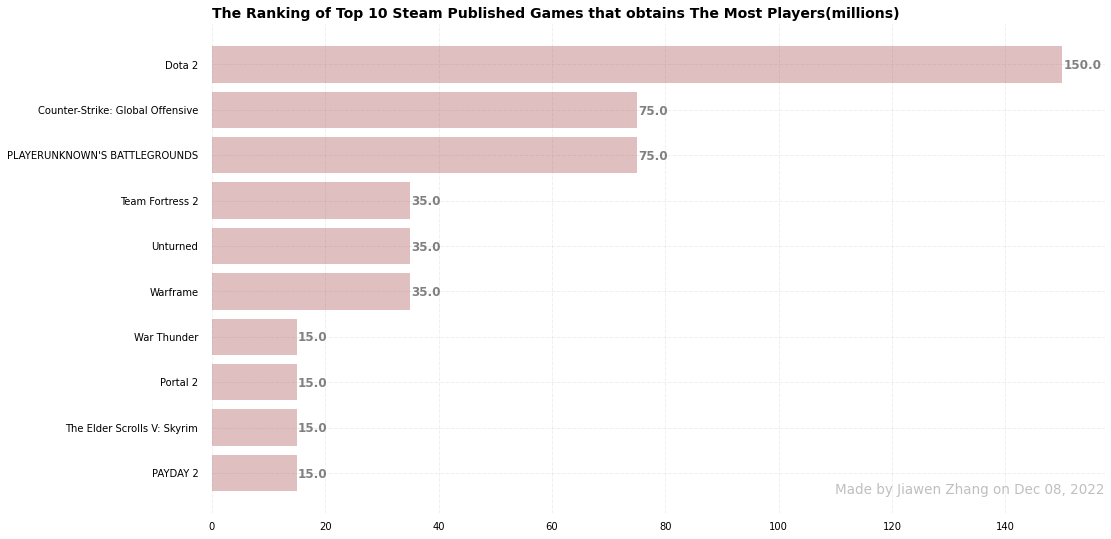

In [32]:
df = steam_numeric_df[['appid', 'name', 'owners']]
df['owners'] = df['owners']/1000000
df_sorted_desc= df.sort_values('owners',ascending=False)
 
name_col = df_sorted_desc['name'].head(10)
owners_col = df_sorted_desc['owners'].head(10)
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name_col, owners_col, color='maroon', alpha=0.25)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.25)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 12, fontweight ='bold', color ='grey')
 
# Add Plot Title
ax.set_title('The Ranking of Top 10 Steam Published Games that obtains The Most Players(millions)', loc ='left', fontsize = 14, fontweight ='bold')
 
# Add Text watermark
fig.text(0.9, 0.15, 'Made by Jiawen Zhang on Dec 08, 2022', fontsize = 13.5, color ='grey', ha ='right', va ='bottom', alpha = 0.5)
 
# Show Plot
plt.show()

**Section 2.2.4 - Plot the ranking of the price of each published steam game**

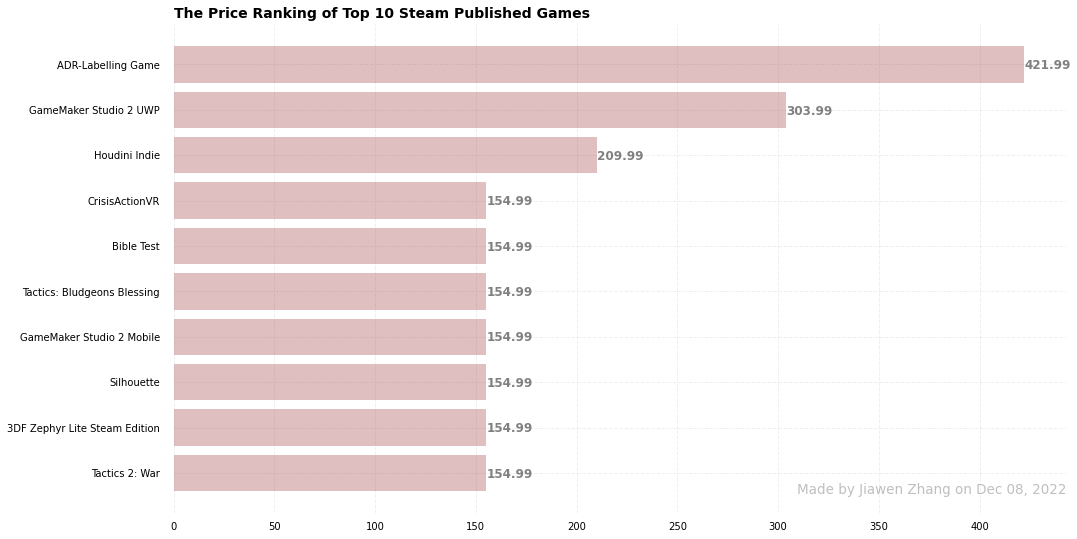

In [33]:
df = steam_numeric_df[['appid', 'name', 'price']]
df_sorted_desc= df.sort_values('price',ascending=False)
 
name_col = df_sorted_desc['name'].head(10)
price_col = df_sorted_desc['price'].head(10)
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name_col, price_col, color='maroon', alpha=0.25)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.25)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 12, fontweight ='bold', color ='grey')
 
# Add Plot Title
ax.set_title('The Price Ranking of Top 10 Steam Published Games', loc ='left', fontsize = 14, fontweight ='bold')
 
# Add Text watermark
fig.text(0.9, 0.15, 'Made by Jiawen Zhang on Dec 08, 2022', fontsize = 13.5, color ='grey', ha ='right', va ='bottom', alpha = 0.5)
 
# Show Plot
plt.show()

*   Extra Work


In [34]:
developers_list = list(sorted_developers_dict.keys())
top1_developer_df = steam_df[steam_df['developer'] == developers_list[0]]

In [35]:
top1_developer_df.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price', 'year',
       'total_ratings', 'pos_rate'],
      dtype='object')

In [36]:
top1_developer_df = top1_developer_df[['appid', 'name', 'categories', 'genres', 'steamspy_tags', 'achievements', 'median_playtime', 'owners', 'price', 'year', 'pos_rate']]
top1_developer_df.head(1)

,appid,name,categories,genres,steamspy_tags,achievements,median_playtime,owners,price,year,pos_rate
3197,299540,Heroes Rise: The Prodigy,"[Single-player, Steam Achievements, Captions a...","[Indie, RPG]","[Choose Your Own Adventure, RPG, Text-Based]",17,0,35000.0,2.89,2014,0.86197


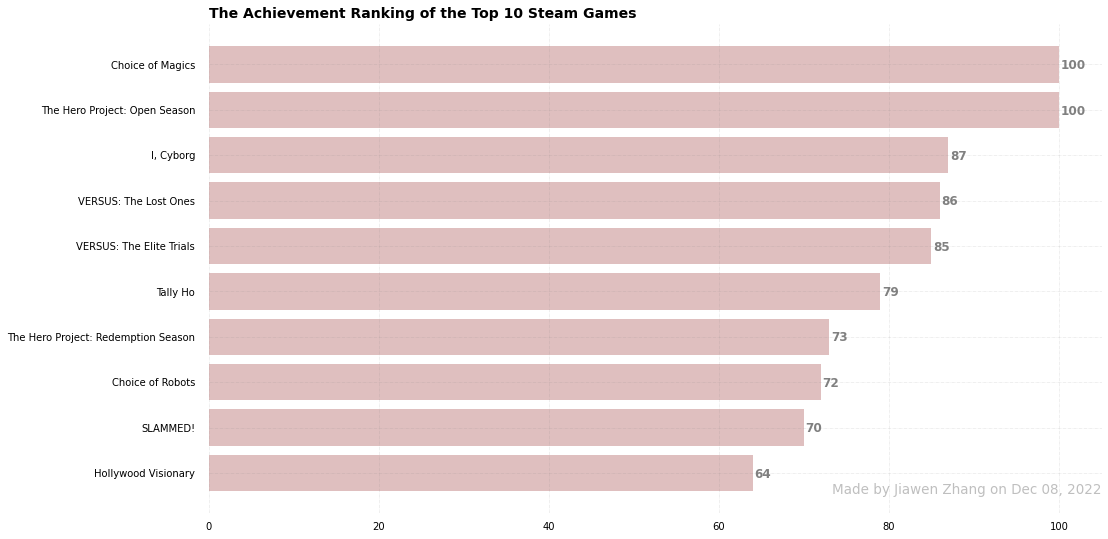

In [37]:
df = top1_developer_df[['appid', 'name', 'achievements']]
df_sorted_desc= df.sort_values('achievements',ascending=False)
 
name_col = df_sorted_desc['name'].head(10)
achievements_col = df_sorted_desc['achievements'].head(10)
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name_col, achievements_col, color='maroon', alpha=0.25)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.25)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 12, fontweight ='bold', color ='grey')
 
# Add Plot Title
ax.set_title('The Achievement Ranking of the Top 10 Steam Games', loc ='left', fontsize = 14, fontweight ='bold')
 
# Add Text watermark
fig.text(0.9, 0.15, 'Made by Jiawen Zhang on Dec 08, 2022', fontsize = 13.5, color ='grey', ha ='right', va ='bottom', alpha = 0.5)
 
# Show Plot
plt.show()

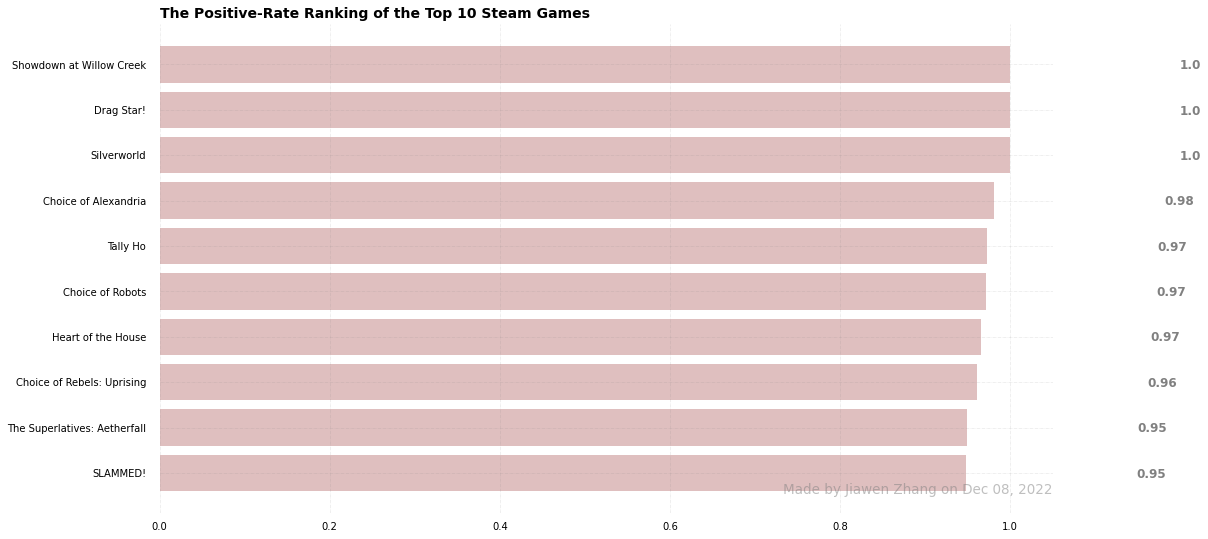

In [38]:
df = top1_developer_df[['appid', 'name', 'pos_rate']]
df_sorted_desc= df.sort_values('pos_rate',ascending=False)
 
name_col = df_sorted_desc['name'].head(10)
pos_rate_col = df_sorted_desc['pos_rate'].head(10)
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name_col, pos_rate_col, color='maroon', alpha=0.25)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.25)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 12, fontweight ='bold', color ='grey')
 
# Add Plot Title
ax.set_title('The Positive-Rate Ranking of the Top 10 Steam Games', loc ='left', fontsize = 14, fontweight ='bold')
 
# Add Text watermark
fig.text(0.9, 0.15, 'Made by Jiawen Zhang on Dec 08, 2022', fontsize = 13.5, color ='grey', ha ='right', va ='bottom', alpha = 0.5)
 
# Show Plot
plt.show()

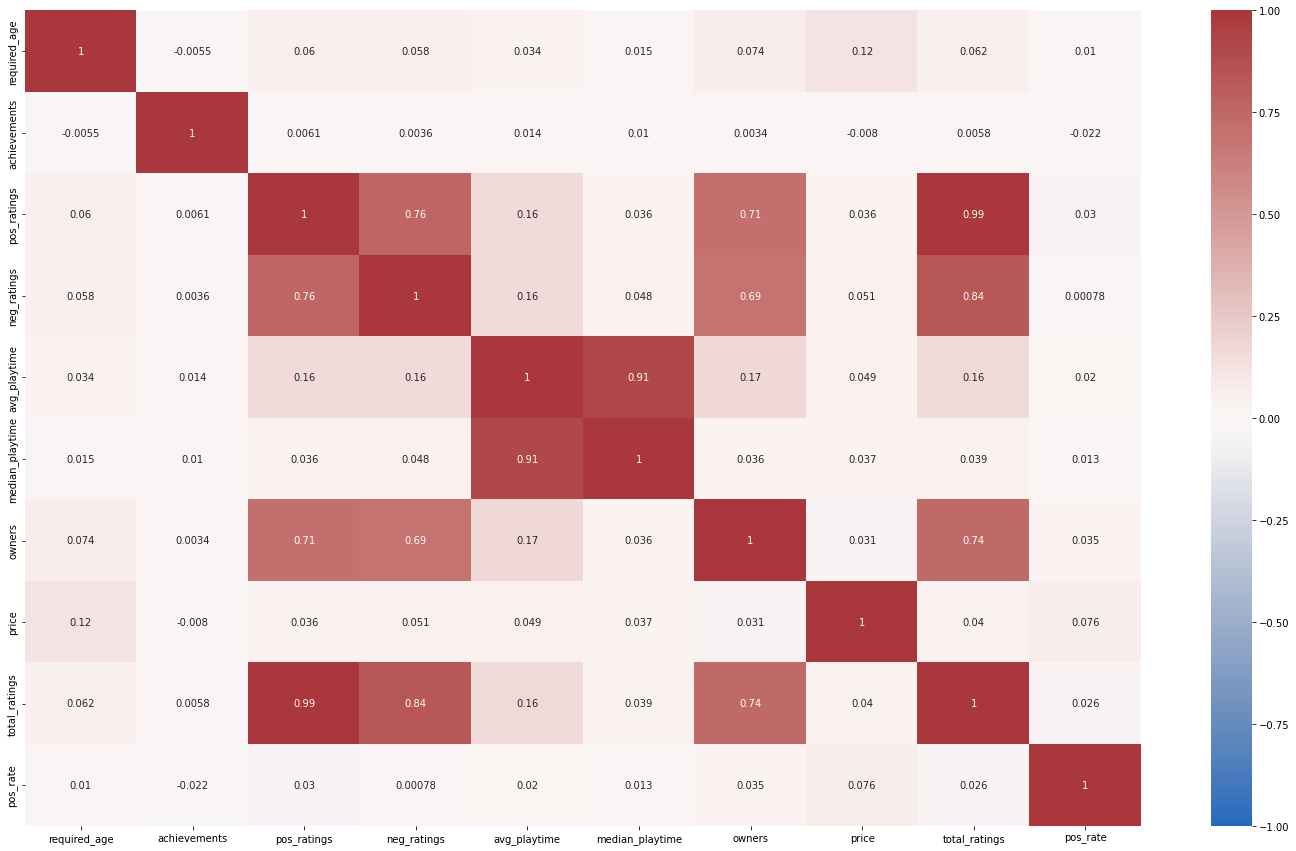

In [39]:
data = steam_numeric_df.drop(labels=['appid'], axis=1).corr()
plt.figure(figsize=(25, 15))

sns.heatmap(data, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()
# sns.lmplot(x="pos_ratings", y="owners", data=steam_numeric_df)
# sns.scatterplot(x="pos_ratings", y="owners", data=steam_numeric_df)
# sns.lmplot(x="neg_ratings", y="owners", data=steam_numeric_df)
# sns.scatterplot(x="neg_ratings", y="owners", data=steam_numeric_df)
# sns.lmplot(x="total_ratings", y="owners", data=steam_numeric_df)
# sns.scatterplot(x="total_ratings", y="owners", data=steam_numeric_df)

In [40]:
updated_steam_numeric_df = steam_numeric_df[['appid', 'name', 'pos_ratings', 'neg_ratings', 'total_ratings', 'owners']]

In [41]:
steam_numeric_df['pos_ratings']

0        124534
1          3318
2          3416
3          1273
4          5250
          ...  
27070         3
27071         8
27072         0
27073         2
27074         4
Name: pos_ratings, Length: 27075, dtype: int64

In [42]:
steam_numeric_df['owners'] = steam_numeric_df['owners'] / 1000
steam_numeric_df.describe()

<ipython-input-42-b0d6897dc4a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_numeric_df['owners'] = steam_numeric_df['owners'] / 1000


,appid,required_age,achievements,pos_ratings,neg_ratings,avg_playtime,median_playtime,owners,price,total_ratings,pos_rate
count,2.707500e+04,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000,27075.000000,2.707500e+04,27075.000000
mean,5.962035e+05,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,134.090489,6.078193,1.211586e+03,0.714478
std,2.508942e+05,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,1328.088582,7.874922,2.242909e+04,0.233594
min,1.000000e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,10.000000,0.000000,1.000000e+00,0.000000
25%,4.012300e+05,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,10.000000,1.690000,1.000000e+01,0.583330
50%,5.990700e+05,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,10.000000,3.990000,3.600000e+01,0.760330
75%,7.987600e+05,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,35.000000,7.190000,1.760000e+02,0.893905
max,1.069460e+06,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,150000.000000,421.990000,3.046717e+06,1.000000


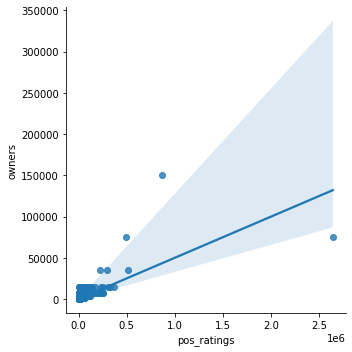

In [43]:
sns.lmplot(x="pos_ratings", y="owners", data=steam_numeric_df)

# Data Mining for Steam Data

In [44]:
steam_array_df.head(1)

,appid,name,platforms,categories,genres,steamspy_tags
0,10,Counter-Strike,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"


**Section 3.1 - Platforms**

In [45]:
platforms_list = ['windows', 'mac', 'linux']

In [46]:
platform_binarizer = MultiLabelBinarizer()
platform_matrix = platform_binarizer.fit_transform(steam_array_df['platforms'])
platform_binarizer = pd.DataFrame(platform_matrix, columns=platform_binarizer.classes_)
platform_binarizer = platform_binarizer[platforms_list]

In [47]:
platform_binarizer.sum(axis=0).sort_values(ascending=False)

windows    27070
mac         8066
linux       5235
dtype: int64

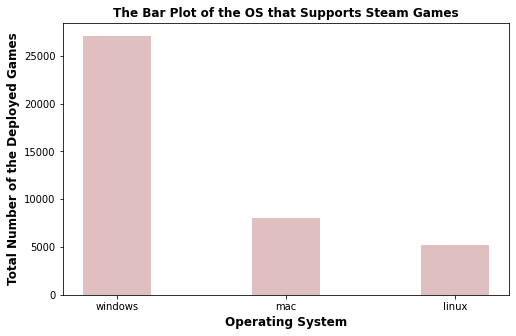

In [48]:
data = { 'windows': 27070, 'mac': 8066, 'linux': 5235 }
operating_systems = list(data.keys())
system_num = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(operating_systems, system_num, color ='maroon', width = 0.4, alpha=0.25)
 
plt.xlabel("Operating System", fontweight='bold', fontsize = 12)
plt.ylabel("Total Number of the Deployed Games", fontweight='bold', fontsize = 12)
plt.title("The Bar Plot of the OS that Supports Steam Games", fontweight='bold', fontsize = 12)
plt.show()

> **Conclusion**: Obviously, the Windows has a dominat status in the published steam games, and mac system relatively outweighes linux system, and I probably presume that linux is too professional to let the average people to use readily since it requires users' strong understanding of linux commands and programming knwoledge. 


In [49]:
df_sorted_desc = platform_binarizer.sum(axis=0).sort_values(ascending=False)[:3]

**Section 3.2 - Categories**

In [50]:
categories_binarizer = MultiLabelBinarizer()
platform_matrix = categories_binarizer.fit_transform(steam_array_df['categories'])
categories_binarizer = pd.DataFrame(platform_matrix, columns=categories_binarizer.classes_)
categories_binarizer = categories_binarizer[category_tags_list]

In [51]:
categories_binarizer.sum(axis=0).sort_values(ascending=False)[:10]

Single-player                 25678
Steam Achievements            14130
Steam Trading Cards            7918
Steam Cloud                    7219
Full controller support        5695
Partial Controller Support     4234
Multi-player                   3974
Steam Leaderboards             3439
Online Multi-Player            2487
Shared/Split Screen            2152
dtype: int64

> **Conclusion**: Categories `Single-Player` and `Steam Achievements` has obvious dominance in all the Steam gams here.

**Section 3.3 - Genres**

In [52]:
genres_binarizer = MultiLabelBinarizer()
platform_matrix = genres_binarizer.fit_transform(steam_array_df['genres'])
genres_binarizer = pd.DataFrame(platform_matrix, columns=genres_binarizer.classes_)
genres_binarizer = genres_binarizer[genres_list]

In [53]:
genres_binarizer.sum(axis=0).sort_values(ascending=False)[:10]

Indie           19421
Action          11903
Casual          10210
Adventure       10032
Strategy         5247
Simulation       5194
RPG              4311
Early Access     2954
Free to Play     1704
Sports           1322
dtype: int64

> **Conclusion**: Genre called `Indie` obtains the absolute dominance, and genres, such as `Action`, `Casual` and `Adventure` share secondary dominance.

In [54]:
genres_ranking_df = pd.DataFrame(genres_binarizer.sum(axis=0).sort_values(ascending=False)[:10])
genres_ranking_df.reset_index(inplace=True)
genres_ranking_df.head(1)

,index,0
0,Indie,19421


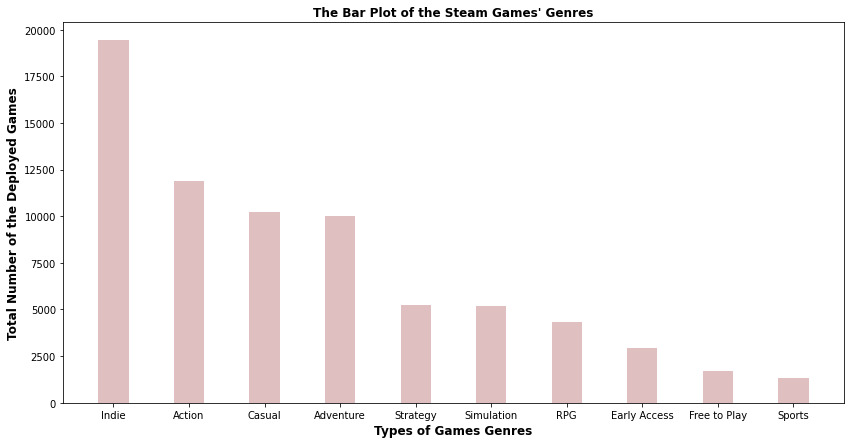

In [55]:
data = dict()
for index, row in genres_ranking_df.iterrows():
  data[row['index']] = row[0]
operating_systems = list(data.keys())
system_num = list(data.values())
  
fig = plt.figure(figsize = (14, 7))
 
# creating the bar plot
plt.bar(operating_systems, system_num, color ='maroon', width = 0.4, alpha=0.25)
 
plt.xlabel("Types of Games Genres", fontweight='bold', fontsize = 12)
plt.ylabel("Total Number of the Deployed Games", fontweight='bold', fontsize = 12)
plt.title("The Bar Plot of the Steam Games' Genres", fontweight='bold', fontsize = 12)
plt.show()

**Section 3.4 - Steam Spy Tags**

In [56]:
steamspy_binarizer = MultiLabelBinarizer()
platform_matrix = steamspy_binarizer.fit_transform(steam_array_df['steamspy_tags'])
steamspy_binarizer = pd.DataFrame(platform_matrix, columns=steamspy_binarizer.classes_)
steamspy_binarizer = steamspy_binarizer[spy_tags_list]

In [57]:
steamspy_df = pd.DataFrame(steamspy_binarizer.sum(axis=0).sort_values(ascending=False)[:10])
steamspy_df.reset_index(inplace=True)
steamspy_df.head(1)

,index,0
0,Indie,16232


> **Conclusion**: Genre called `Indie` obtains the absolute dominance, and the genres called `Action` owns a secondary dominance.

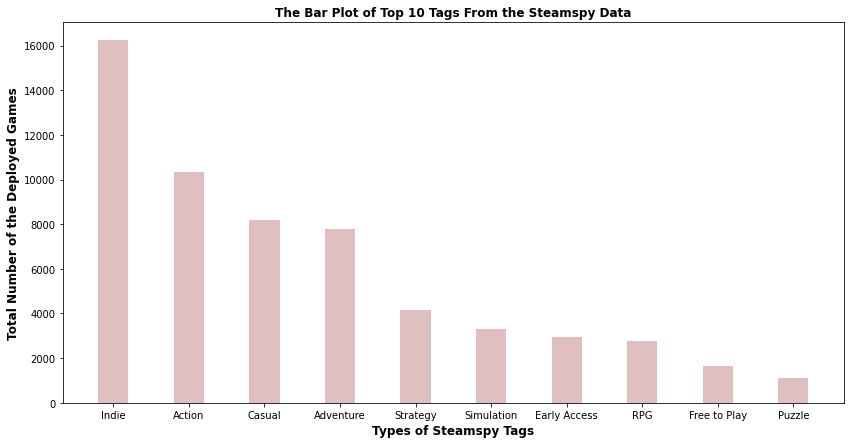

In [58]:
data = dict()
for index, row in steamspy_df.iterrows():
  data[row['index']] = row[0]
operating_systems = list(data.keys())
system_num = list(data.values())
  
fig = plt.figure(figsize = (14, 7))
 
# creating the bar plot
plt.bar(operating_systems, system_num, color ='maroon', width = 0.4, alpha=0.25)
 
plt.xlabel("Types of Steamspy Tags", fontweight='bold', fontsize = 12)
plt.ylabel("Total Number of the Deployed Games", fontweight='bold', fontsize = 12)
plt.title("The Bar Plot of Top 10 Tags From the Steamspy Data", fontweight='bold', fontsize = 12)
plt.show()

**Section 3.5.1 - Create a apriori function called `tag_frequent_itemsets` to seek all the frequent k-itemsets with a minimal support of `min_support` in the emoji dataset. In other words, k and min_support should be arguments that are passed when the function is called, in addition to the matrix itself.**

In [59]:
def tag_frequent_itemsets(df, k, min_support):
  frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
  frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda item: len(item))
  smaller_scope = frequent_itemsets[frequent_itemsets['length'] == k]
  return smaller_scope[['support', 'itemsets']]

**Section 3.5.2 - Find all frequent `3-itemsets` for a min support of `0.007` with the self-designated function `tag_frequent_itemsets`**

In [60]:
freq_itemsets3_platforms = tag_frequent_itemsets(platform_binarizer, 3, 0.007)
freq_itemsets3_categories = tag_frequent_itemsets(categories_binarizer, 3, 0.007)
freq_itemsets3_henres = tag_frequent_itemsets(genres_binarizer, 3, 0.007)
freq_itemsets3_steamspy = tag_frequent_itemsets(steamspy_binarizer, 3, 0.007)

In [61]:
freq_itemsets3_steamspy.head()

,support,itemsets
93,0.011376,"(Action, Indie, Strategy)"
94,0.007793,"(Action, Indie, RPG)"
95,0.054515,"(Action, Casual, Indie)"
96,0.056916,"(Action, Adventure, Indie)"
97,0.007498,"(Platformer, Action, Indie)"


**Section 3.6.1 - Create a function called `generate_candidate_3_itemsets` that takes in a list of frequent 2-itemsets, and returns a list of the candidate 3-itemsets (`candidate` means that they may or may not be frequent).**

Please represent each itemset as a `set` in Python. Make sure that for each candidate 3-itemset in your returned list, at least one of its size-2 subset is a frequent 2-itemset, and your list does not contain duplicated itemsets.

In [62]:
def generate_candidate_3_itemsets(arr):
  result = set()
  for ele1 in arr:
    for ele2 in arr:
      tempSet = ele1.union(ele2)
      if(len(tempSet) == 5): result.add(frozenset(tempSet))

  return list(result)

In [63]:
frequent3_itemsets_arr = generate_candidate_3_itemsets(freq_itemsets3_steamspy['itemsets'].tolist())
frequent3_itemsets_arr[:3]
# print(len(frequent3_itemsets_arr))

[frozenset({'Casual', 'Indie', 'Puzzle', 'Simulation', 'Strategy'}),
 frozenset({'Adventure', 'Casual', 'Indie', 'RPG', 'Strategy'}),
 frozenset({'Action', 'Adventure', 'Casual', 'Indie', 'Strategy'})]

**3.6.2 - Frequent Itemsets Evaluation**

In [64]:
def mi(antecedent_support, consequent_support, support):
  leftTrue = antecedent_support
  rightTrue = consequent_support
  leftFalse = 1 - leftTrue
  rightFalse = 1 - rightTrue

  bothTrue = support
  leftTrue_rightFalse = antecedent_support - support
  leftFalse_rightTrue = consequent_support - support
  bothFalse = 1 - bothTrue - leftTrue_rightFalse - leftFalse_rightTrue

  result = bothTrue * math.log2(bothTrue / (leftTrue * rightTrue)) + leftFalse_rightTrue * math.log2(leftFalse_rightTrue / (leftFalse * rightTrue)) + leftTrue_rightFalse * math.log2(leftTrue_rightFalse / (leftTrue * rightFalse)) + bothFalse * math.log2(bothFalse / (leftFalse * rightFalse))
  
  return result



*   Itemset Eveluation about Steam Spy


In [65]:
platform_frequent_itemsets = apriori(platform_binarizer, min_support=0.005, use_colnames=True)
platform_rules = association_rules(platform_frequent_itemsets, metric="lift", min_threshold=3)

categories_frequent_itemsets = apriori(categories_binarizer, min_support=0.005, use_colnames=True)
categories_rules = association_rules(categories_frequent_itemsets, metric="lift", min_threshold=3)

genres_frequent_itemsets = apriori(genres_binarizer, min_support=0.005, use_colnames=True)
genres_rules = association_rules(genres_frequent_itemsets, metric="lift", min_threshold=3)

steamspy_frequent_itemsets = apriori(steamspy_binarizer, min_support=0.005, use_colnames=True)
steamspy_rules = association_rules(steamspy_frequent_itemsets, metric="lift", min_threshold=3)

In [66]:
mutualInfo = []
for idx, row in platform_rules.iterrows():
  mutualResult = mi(row['antecedent support'], row['consequent support'], row['support'])
  mutualInfo.append(mutualResult)
platform_rules['mutualInfo'] = mutualInfo
platform_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutualInfo


In [67]:
mutualInfo = []
for idx, row in categories_rules.iterrows():
  mutualResult = mi(row['antecedent support'], row['consequent support'], row['support'])
  mutualInfo.append(mutualResult)
categories_rules['mutualInfo'] = mutualInfo
categories_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutualInfo
0,(Multi-player),(Online Multi-Player),0.146777,0.091856,0.064968,0.442627,4.818709,0.051485,1.629329,0.124965
1,(Online Multi-Player),(Multi-player),0.091856,0.146777,0.064968,0.707278,4.818709,0.051485,2.914786,0.124965
2,(Multi-player),(Local Multi-Player),0.146777,0.059649,0.035679,0.243080,4.075165,0.026924,1.242339,0.050985
3,(Local Multi-Player),(Multi-player),0.059649,0.146777,0.035679,0.598142,4.075165,0.026924,2.123196,0.050985
4,(Multi-player),(Cross-Platform Multiplayer),0.146777,0.039926,0.031801,0.216658,5.426478,0.025940,1.225613,0.065056
...,...,...,...,...,...,...,...,...,...,...
27639,"(Steam Cloud, Shared/Split Screen)","(Steam Trading Cards, Steam Achievements, Loca...",0.032244,0.009788,0.006316,0.195876,20.012643,0.006000,1.231418,0.023172
27640,"(Full controller support, Shared/Split Screen)","(Steam Trading Cards, Steam Achievements, Loca...",0.047350,0.008864,0.006316,0.133385,15.047533,0.005896,1.143687,0.020884
27641,(Local Co-op),"(Steam Trading Cards, Steam Achievements, Sing...",0.039114,0.014663,0.006316,0.161473,11.012302,0.005742,1.175081,0.016230
27642,(Full controller support),"(Steam Trading Cards, Steam Achievements, Loca...",0.210342,0.007387,0.006316,0.030026,4.064816,0.004762,1.023340,0.010259


In [68]:
mutualInfo = []
for idx, row in genres_rules.iterrows():
  mutualResult = mi(row['antecedent support'], row['consequent support'], row['support'])
  mutualInfo.append(mutualResult)
genres_rules['mutualInfo'] = mutualInfo
genres_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutualInfo
0,(Free to Play),(Massively Multiplayer),0.062936,0.026704,0.012890,0.204812,7.669835,0.011209,1.223983,0.027724
1,(Massively Multiplayer),(Free to Play),0.026704,0.062936,0.012890,0.482711,7.669835,0.011209,1.811489,0.027724
2,(Racing),(Sports),0.037821,0.048827,0.012853,0.339844,6.960113,0.011006,1.440830,0.024942
3,(Sports),(Racing),0.048827,0.037821,0.012853,0.263238,6.960113,0.011006,1.305956,0.024942
4,(Violent),(Gore),0.031136,0.019834,0.016510,0.530249,26.734627,0.015892,2.086566,0.077450
...,...,...,...,...,...,...,...,...,...,...
183,"(Casual, Strategy)","(Indie, RPG, Simulation)",0.070729,0.021644,0.005503,0.077807,3.594913,0.003972,1.060902,0.005215
184,"(Adventure, Indie, Simulation)","(Casual, RPG)",0.042253,0.036491,0.007239,0.171329,4.695065,0.005697,1.162715,0.009271
185,"(Casual, Indie, RPG)","(Adventure, Simulation)",0.032170,0.052595,0.007239,0.225029,4.278548,0.005547,1.222504,0.008432
186,"(Adventure, Simulation)","(Casual, Indie, RPG)",0.052595,0.032170,0.007239,0.137640,4.278548,0.005547,1.122305,0.008432


**2.4 Itemset Similarity**

In [69]:
def list_intersection(A, B):
  result = []
  for A_ele in A:
    for B_ele in B:
      if A_ele == B_ele:
        result.append(A_ele)
  return result

def list_union(A, B):
  result = []
  for A_ele in A:
    result.append(A_ele)
  for B_ele in B:
    if B_ele not in result:
      result.append(B_ele)
  return result

def jaccard_similtarity(A, B):
  intersection = list_intersection(A, B)
  union = list_union(A, B)
  return 0 if (len(intersection) == 0) else len(intersection)/len(union)

In [70]:
steam_array_df.head(1)

,appid,name,platforms,categories,genres,steamspy_tags
0,10,Counter-Strike,"[windows, mac, linux]","[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]"


In [71]:
platforms_compare_df = steam_array_df.copy().drop(labels=['categories', 'genres', 'steamspy_tags'], axis=1)
platforms_compare_df['similarity'] = 0.000

compare_samples1 = platforms_compare_df.loc[0]['platforms']
for (idx, row) in platforms_compare_df.iterrows():
  compare_samples2 = row['platforms']
  platforms_compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)

<ipython-input-71-3575483eb7c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platforms_compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)


In [72]:
platforms_compare_df.sort_values(by=['similarity'], ascending=False).head(500)

,appid,name,platforms,similarity
0,10,Counter-Strike,"[windows, mac, linux]",1.0
13975,612570,Fort Triumph,"[windows, mac, linux]",1.0
4512,341150,Age of Fear 2: The Chaos Lord GOLD,"[windows, mac, linux]",1.0
4510,341090,On A Roll 3D,"[windows, mac, linux]",1.0
13943,611830,Park Bound,"[windows, mac, linux]",1.0
...,...,...,...,...
12143,559610,Love Ribbon,"[windows, mac, linux]",1.0
12148,559850,Time Tenshi 2: Special Edition,"[windows, mac, linux]",1.0
12151,559910,Terroir,"[windows, mac, linux]",1.0
12153,559930,Causality,"[windows, mac, linux]",1.0


In [73]:
categories_compare_df = steam_array_df.copy().drop(labels=['platforms', 'genres', 'steamspy_tags'], axis=1)
categories_compare_df['similarity'] = 0.000

compare_samples1 = categories_compare_df.loc[0]['categories']
for (idx, row) in categories_compare_df.iterrows():
  compare_samples2 = row['categories']
  categories_compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)

<ipython-input-73-6ee3a4bb244d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories_compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)


In [74]:
categories_compare_df.sort_values(by=['similarity'], ascending=False).head(500)

,appid,name,categories,similarity
0,10,Counter-Strike,"[Multi-player, Online Multi-Player, Local Mult...",1.000000
3,40,Deathmatch Classic,"[Multi-player, Online Multi-Player, Local Mult...",1.000000
1,20,Team Fortress Classic,"[Multi-player, Online Multi-Player, Local Mult...",1.000000
3465,308540,SLEEPOVER,"[Multi-player, Online Multi-Player, Local Mult...",0.750000
17657,722620,Fatal Velocity: Physics Combat,"[Multi-player, Online Multi-Player, Local Mult...",0.750000
...,...,...,...,...
14662,636930,Soundscape VR,"[Single-player, Multi-player, Online Multi-Pla...",0.333333
25057,955410,Armoured Alliance,"[Single-player, Multi-player, Online Multi-Pla...",0.333333
24244,924310,VIDEO GAME,"[Multi-player, Local Multi-Player, Shared/Spli...",0.333333
24261,924960,Conjure Strike,"[Multi-player, Online Multi-Player, Cross-Plat...",0.333333


In [117]:
categories_ranking_df = pd.DataFrame(categories_compare_df.sort_values(by=['similarity'], ascending=False)[:10])
categories_ranking_df.reset_index(inplace=True)
categories_ranking1 = categories_ranking_df[['name', 'categories']]
categories_ranking2 = categories_ranking_df[['name', 'similarity']]

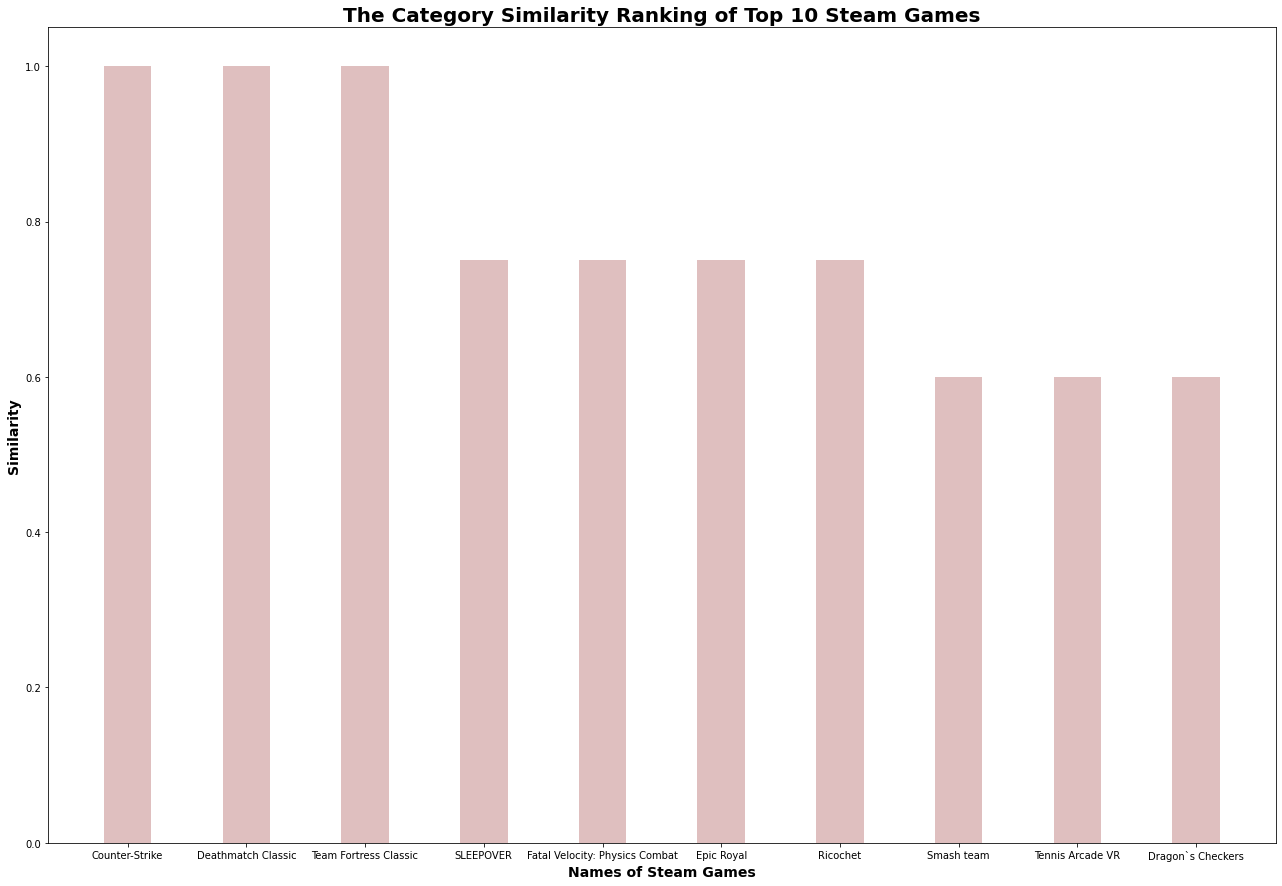

In [144]:
data = dict()
for index, row in categories_ranking2.iterrows():
  data[row['name']] = row[1]
names = list(data.keys())
similarity = list(data.values())

# create the bar plot
fig = plt.figure(figsize = (22, 15))
plt.bar(names, similarity, color ='maroon', width = 0.4, alpha=0.25)
plt.xlabel("Names of Steam Games", fontweight='bold', fontsize = 14)
plt.ylabel("Similarity", fontweight='bold', fontsize = 14)
plt.title("The Category Similarity Ranking of Top 10 Steam Games", fontweight='bold', fontsize = 20)
plt.show()

In [135]:
for index, row in categories_ranking1.iterrows():
  category_name = row['name']
  category_similiarity = ''
  for string in row['categories']:
    category_similiarity += f' ,{string}'
  category_similiarity = category_similiarity[2:]
  print(f'{category_name}: {category_similiarity}.\n')

Counter-Strike: Multi-player ,Online Multi-Player ,Local Multi-Player ,Valve Anti-Cheat enabled.

Deathmatch Classic: Multi-player ,Online Multi-Player ,Local Multi-Player ,Valve Anti-Cheat enabled.

Team Fortress Classic: Multi-player ,Online Multi-Player ,Local Multi-Player ,Valve Anti-Cheat enabled.

SLEEPOVER: Multi-player ,Online Multi-Player ,Local Multi-Player.

Fatal Velocity: Physics Combat: Multi-player ,Online Multi-Player ,Local Multi-Player.

Epic Royal: Multi-player ,Online Multi-Player ,Local Multi-Player.

Ricochet: Multi-player ,Online Multi-Player ,Valve Anti-Cheat enabled.

Smash team: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Tennis Arcade VR: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Dragon`s Checkers: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.



In [75]:
genres_compare_df = steam_array_df.copy().drop(labels=['platforms', 'categories', 'steamspy_tags'], axis=1)
genres_compare_df['similarity'] = 0.000

compare_samples1 = genres_compare_df.loc[0]['genres']
for (idx, row) in genres_compare_df.iterrows():
  compare_samples2 = row['genres']
  genres_compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)

<ipython-input-75-fa569b8e5b11>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)


In [136]:
genres_compare_df.sort_values(by=['similarity'], ascending=False).head(500)

,appid,name,genres,similarity
0,10,Counter-Strike,[Action],1.0
13527,598840,Ninja Shodown,[Action],1.0
883,47780,Dead Space™ 2,[Action],1.0
884,47790,Medal of Honor™,[Action],1.0
13511,598450,"Slice, Dice & Rice",[Action],1.0
...,...,...,...,...
20888,816020,JUMP FORCE,[Action],1.0
7070,410320,EARTH DEFENSE FORCE 4.1 The Shadow of New Despair,[Action],1.0
1270,205950,Jet Set Radio,[Action],1.0
6838,403400,ARCADE GAME SERIES: DIG DUG,[Action],1.0


In [140]:
genres_ranking_df = pd.DataFrame(genres_compare_df.sort_values(by=['similarity'], ascending=False)[:10])
genres_ranking_df.reset_index(inplace=True)
genres_ranking_df1 = genres_ranking_df[['name', 'genres']]
genres_ranking_df2 = genres_ranking_df[['name', 'similarity']]

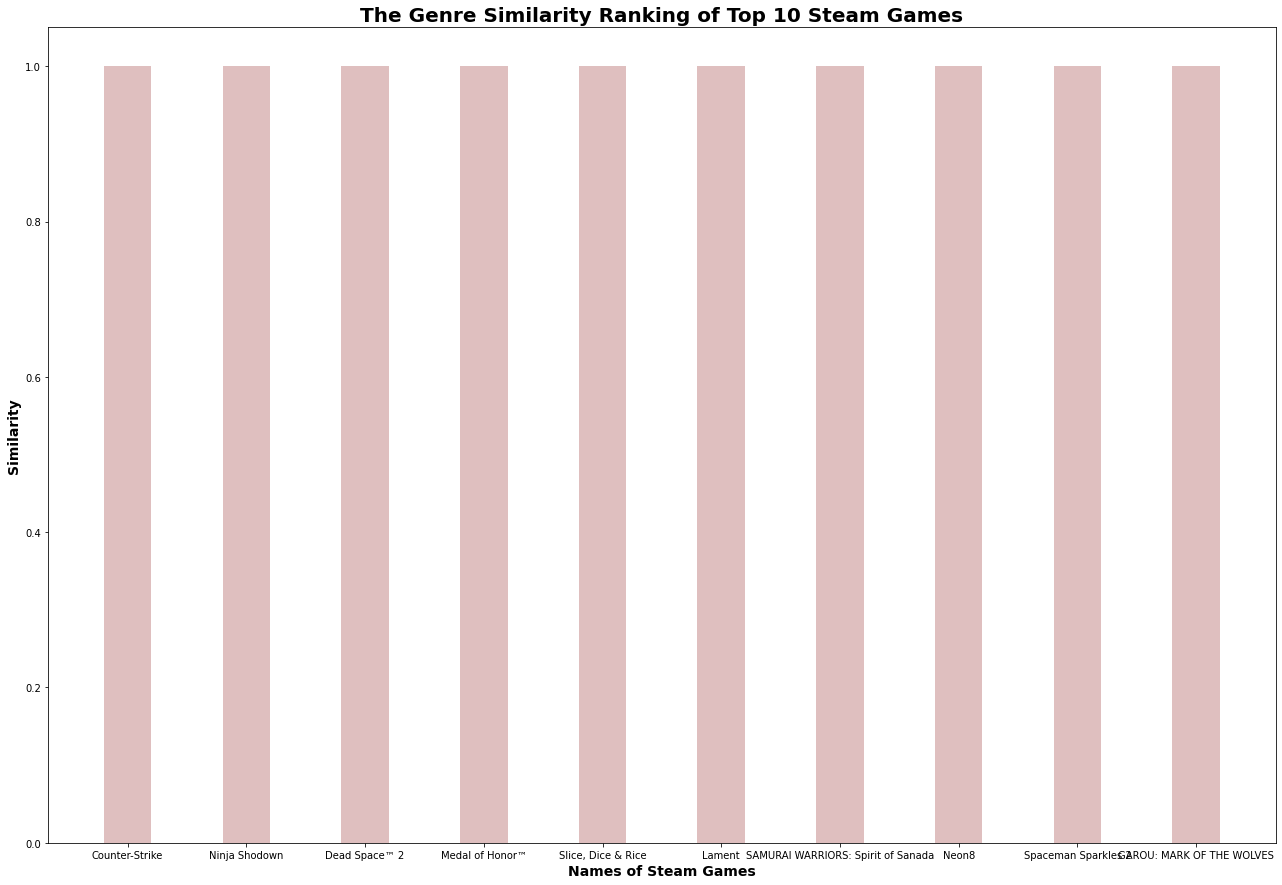

In [148]:
data = dict()
for index, row in genres_ranking_df2.iterrows():
  data[row['name']] = row[1]
names = list(data.keys())
similarity = list(data.values())


# create the bar plot
fig = plt.figure(figsize = (22, 15))
plt.bar(names, similarity, color ='maroon', width = 0.4, alpha=0.25)
plt.xlabel("Names of Steam Games", fontweight='bold', fontsize = 14)
plt.ylabel("Similarity", fontweight='bold', fontsize = 14)
plt.title("The Genre Similarity Ranking of Top 10 Steam Games", fontweight='bold', fontsize = 20)
plt.show()

In [147]:
for index, row in genres_ranking_df1.iterrows():
  genre_name = row['name']
  genre_similiarity = ''
  for string in row['genres']:
    genre_similiarity += f' ,{string}'
  genre_similiarity = category_similiarity
  print(f'{genre_name}: {genre_similiarity}.\n')

Counter-Strike: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Ninja Shodown: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Dead Space™ 2: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Medal of Honor™: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Slice, Dice & Rice: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Lament: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

SAMURAI WARRIORS: Spirit of Sanada: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Neon8: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

Spaceman Sparkles 2: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.

GAROU: MARK OF THE WOLVES: Single-player ,Multi-player ,Online Multi-Player ,Local Multi-Player.



In [77]:
steamspy_tags_compare_df = steam_array_df.copy().drop(labels=['platforms', 'categories', 'genres'], axis=1)
steamspy_tags_compare_df['similarity'] = 0.000

compare_samples1 = steamspy_tags_compare_df.loc[0]['steamspy_tags']
for (idx, row) in steamspy_tags_compare_df.iterrows():
  compare_samples2 = row['steamspy_tags']
  steamspy_tags_compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)

<ipython-input-77-1508ce6dbbdf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steamspy_tags_compare_df['similarity'][idx] = jaccard_similtarity(compare_samples1, compare_samples2)


In [78]:
steamspy_tags_compare_df.sort_values(by=['similarity'], ascending=False).head(500)

,appid,name,steamspy_tags,similarity
0,10,Counter-Strike,"[Action, FPS, Multiplayer]",1.000000
15,360,Half-Life Deathmatch: Source,"[Action, FPS, Multiplayer]",1.000000
927,55100,Homefront,"[Action, FPS, Multiplayer]",1.000000
60,2450,Bloody Good Time,"[Action, Multiplayer, FPS]",1.000000
330,13210,Unreal Tournament 3 Black,"[FPS, Action, Multiplayer]",1.000000
...,...,...,...,...
876,47110,Escape From Paradise,[Action],0.333333
19686,781240,Mystical,[Action],0.333333
16653,693950,カニマン VS メカモンキー,[Action],0.333333
17545,719070,BlowOut,[Action],0.333333


# Machine Learning for Steam Data

In [79]:
updated_steam_numeric_df.describe()

,appid,pos_ratings,neg_ratings,total_ratings,owners
count,2.707500e+04,2.707500e+04,27075.000000,2.707500e+04,2.707500e+04
mean,5.962035e+05,1.000559e+03,211.027147,1.211586e+03,1.340905e+05
std,2.508942e+05,1.898872e+04,4284.938531,2.242909e+04,1.328089e+06
min,1.000000e+01,0.000000e+00,0.000000,1.000000e+00,1.000000e+04
25%,4.012300e+05,6.000000e+00,2.000000,1.000000e+01,1.000000e+04
50%,5.990700e+05,2.400000e+01,9.000000,3.600000e+01,1.000000e+04
75%,7.987600e+05,1.260000e+02,42.000000,1.760000e+02,3.500000e+04
max,1.069460e+06,2.644404e+06,487076.000000,3.046717e+06,1.500000e+08


In [80]:
updated_steam_numeric_df

,appid,name,pos_ratings,neg_ratings,total_ratings,owners
0,10,Counter-Strike,124534,3339,127873,15000000.0
1,20,Team Fortress Classic,3318,633,3951,7500000.0
2,30,Day of Defeat,3416,398,3814,7500000.0
3,40,Deathmatch Classic,1273,267,1540,7500000.0
4,50,Half-Life: Opposing Force,5250,288,5538,7500000.0
...,...,...,...,...,...,...
27070,1065230,Room of Pandora,3,0,3,10000.0
27071,1065570,Cyber Gun,8,1,9,10000.0
27072,1065650,Super Star Blast,0,1,1,10000.0
27073,1066700,New Yankee 7: Deer Hunters,2,0,2,10000.0


In [81]:
updated_steam_numeric_df.drop(labels=['appid'], axis=1).corr()

,pos_ratings,neg_ratings,total_ratings,owners
pos_ratings,1.000000,0.762804,0.992340,0.713448
neg_ratings,0.762804,1.000000,0.836842,0.690306
total_ratings,0.992340,0.836842,1.000000,0.735892
owners,0.713448,0.690306,0.735892,1.000000


In [82]:
trimmed_steam_numeric_df = steam_numeric_df.drop(labels=['required_age', 'achievements', 'price', 'pos_rate'], axis=1)

In [83]:
X = updated_steam_numeric_df.drop(labels=['appid', 'name', 'owners'], axis=1)
y = updated_steam_numeric_df['owners']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [85]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [86]:
X_train_scaled[:10]

array([[-0.04799107, -0.05684882, -0.04964395],
       [-0.04860317, -0.05684882, -0.05017418],
       [-0.04860317, -0.05627432, -0.05009261],
       [-0.04055165, -0.02611299, -0.03883539],
       [-0.0450718 , -0.05627432, -0.04703358],
       [-0.04747314, -0.05771057, -0.04931765],
       [-0.04483638, -0.05196556, -0.04621784],
       [-0.04879151, -0.05684882, -0.05033733],
       [-0.04888568, -0.05799782, -0.05058205],
       [ 0.06958004,  0.19535736,  0.0880122 ]])

In [87]:
grad_boost_reg_model = GradientBoostingRegressor()
grad_boost_reg_model.fit(X_train_scaled, y_train)
y_pred = grad_boost_reg_model.predict(X_test_scaled)

print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

953460992747.7163
976453.2721783037


In [88]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_scaled, y_train)
y_pred = linear_reg_model.predict(X_test_scaled)

print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

215014880049.56656
463696.97006726987


In [89]:
ridge_reg_model = Ridge()
ridge_reg_model.fit(X_train_scaled, y_train)
y_pred = ridge_reg_model.predict(X_test_scaled)

print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

214982356728.1648
463661.89915515465


In [90]:
lasso_reg_model = Lasso()
lasso_reg_model.fit(X_train_scaled, y_train)
y_pred = lasso_reg_model.predict(X_test_scaled)

print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

269729905213.94684
519355.2784115579


In [91]:
bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)
y_pred = bayesian_ridge_model.predict(X_test_scaled)

print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

214873343422.32382
463544.3273542713


In [92]:
regressors = [
    ("Ridge Regression", Ridge()), 
    # ("Lasso Regression", Lasso()),
    # ("Linear Regression",  LinearRegression()),
    # ("BayesianRidge Regression", BayesianRidge()),
    # ("Gradient Boosting Regression", GradientBoostingRegressor())
]

In [93]:
grid_param = [
            # Ridge Regression
            [{
                'fit_intercept': [True, False], 
                'copy_X': [True, False],
                'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'positive']
             }],
            # # Lasso Regression 
            # [{
            #     'alpha': [0.001, 0.01, 0.1],
            #     'fit_intercept': [True, False],
            #     'copy_X': [True, False],
            #     'max_iter': [10, 100, 1000],
            #     'positive': [True, False],
            #     'selection': ['cyclic', 'random']
            # }],
            # Linear Regression
            # [{
            #     'fit_intercept': [True, False],
            #     'copy_X': [True, False],
            #     'n_jobs': [1, 10, 00, 1000],
            #     'positive': [True, False],
            # }],
            # [{
            # # BayesianRidge Regression
            #     'max_iter': [10, 100, 1000],
            #     'alpha_1': [0.001, 0.01, 0.1],
            #     'alpha_2': [0.001, 0.01, 0.1],
            #     'compute_score': [True, False],
            #     'fit_intercept': [True, False],
            #  }],
            # # Gradient Boosting Regression
            # [{
            #     'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
            #     'learning_rate': [0.001, 0.01, 0.1],
            #     'n_estimators': [1, 10, 100, 1000],
            #     'criterion': ['friedman_mse', 'squared_error']
            #  }]
        ]

In [94]:
for combo, param_settings in zip(regressors, grid_param):  
    best_search = GridSearchCV(estimator=combo[1], param_grid=param_settings, cv=5, scoring='neg_mean_absolute_error')
    best_search.fit(X_train_scaled, y_train)

    best_param = best_search.best_params_
    # print('The best parameter for {} is {}.'.format(combo[1].__class__.__name__, best_param))
    combo[1].set_params(**best_param)
    combo[1].fit(X_train_scaled, y_train)
    y_pred = combo[1].predict(X_test_scaled)
    print(f'\n\nThe Model Type: {combo[1]}')
    print(f'\nThe Score of Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
    print(f'\nThe Squared Score of Mean Squared Error: {math.sqrt(mean_squared_error(y_test, y_pred))}')



The Model Type: Ridge(solver='lsqr')

The Score of Mean Squared Error: 214982356727.98013

The Squared Score of Mean Squared Error: 463661.8991549555


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py", line 1011, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py", line 782, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "/usr/l